# Learning with Perceptrons

This notebook provides a basic overview of producing linear classifiers via the perceptron learning algorithm. Details of the algorithm are covered via an example application concerning the classification of iris flowers (a standard introductory example - see http://goo.gl/1WEiAK, which this notebook borrows from to some extent).

The dataset in question is available through sklearn, and contains 150 examples, each consisting of four features. There are three classes of flower in the dataset, and each class is linearly seperable from the other two. 
So, the goal here is to use a perceptron to define a decision boundary that seperates each class from the other two in a 4-dimensional space. We can visualize this data in by projecting it into 2D subspaces.

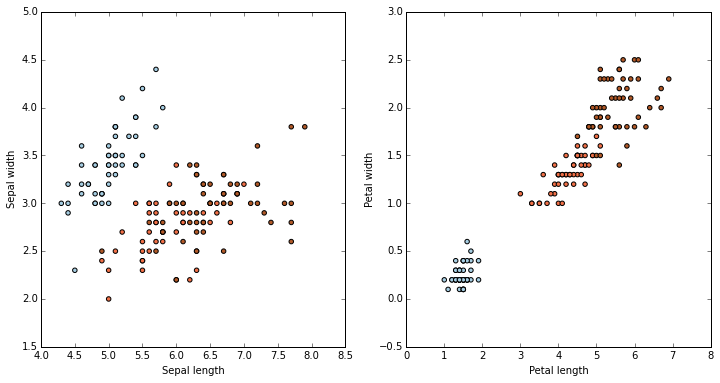

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from sklearn import datasets

# Load the dataset
iris = datasets.load_iris()

# Generate some plots to get an intuitive feel for the dataset.
X = iris.data[:,:2]  
Y = iris.data[:,2:]  
Z = iris.target

fig = plt.figure(figsize=(12,6))
p1 = fig.add_subplot(1,2,1)
p1.scatter(X[:, 0], X[:, 1], c=Z, cmap=plt.cm.Paired)
p1.set_xlabel('Sepal length')
p1.set_ylabel('Sepal width')

p2 = fig.add_subplot(1,2,2)
p2.scatter(Y[:, 0], Y[:, 1], c=Z, cmap=plt.cm.Paired)
p2.set_xlabel('Petal length')
p2.set_ylabel('Petal width')

fig.show()

These plots basically visualize the data in different 2D subspaces of the 4D space. To make a classifier, we want to create a hyperplane in this 4D space that seperates the datapoints corresponding to a particular class from all of the other datapoints. A perceptron solves this problem in a fairly simple manner. We aim to find a good parameter vector $\theta$, which we multiply by each feature vector $x$ (i.e. $\theta^T x$) to assign a score to the datapoint identified by the feature vector. This score is then passed through a step function that assigns it either a value of 1, indicating that it is predicted to belong to the class in question, or -1, indicating that it is predicted to not belong to the class in question. In other words, the classification decision can be expressed as $H(\theta^T x)$ where $H$ is the sign function. 

# Mathematical Details

Intuitively, it is useful to think of the parameter vector as vector that is highly similar to the data vectors in the class it identifies. This similarity results in each data vector having a high dot product with the parameter vector, which in turn makes the data vector likely to be assigned as a positive example of the class (because the score being passed through the step-wise non-linearity is high).

Learning the parameter vector involves minimizing a cost function defined in terms of the total distance between the decision boundary and the training examples that the parameter vector misclassifies. Updating the parameter vector to minimize this cost function is actually quite simple. For each training example, we determine whether the decision boundary makes an error. If the example is incorrectly identified as not belonging to the class, we shift the boundary by making the parameter vector slightly more similar to data vector under consideration. Likewise, if the example is incorrectly identified as belonging to the class, we shift the boundary by making the parameter vector slightly more dissimilar to the data vector under consideration. This procedure is guaranteed to converge on a good decision boundary if the data are linearly seperably. 

Mathematically, we can be a bit more precise. The cost function we want to minimize is defined as follows: 

$J(\theta) = \sum_{i=1}^{m} D_{i}$ 

where m is the number misclassified points, and $D_{i}$ is the distance from the $i^{th}$ point to the decision boundary. We can rewrite this in terms of $\theta$ and $x$ as follows, assuming that the parameter vector is always normalized to unit length, and that the parameter vector and input vector are modified to account for a bias term on the non-linearity:

$J(\theta) = \sum_{i=1}^{m} H(\theta^T x_i)\cdot{\theta^T x_i} $ 

Where $H$ is the decision produced by the classifier given the current weights. This works because if $x_i$ is misclassified positively, then both $H$ and $\theta^T x_i$ will be positive, and if $x_i$ is misclassified negatively, then both $H$ and $\theta^T x_i$and will be negative. As such, the product of these two quantities will always be positive, therefore yielding a cost function that decreases with fewer misclassifications. 

Note that the gradient of this cost function with respect to the parameters is simply $H_i\cdot(x_i)$ for an incorrectly classified training example $x_i$. ($H_i$ denotes the value of $H$ for misclassified point $i$):

$\nabla J(\theta) = H_i\cdot(x_i)$

To update the weight vector on the basis of this gradient, we multiply the gradient by a learning rate and reverse its sign so as to descend rather than ascend:

$\theta := \theta-1 \cdot \eta \cdot H_i \cdot x_i$

Intuitively, this update rule adds a scaled version of the input vector to the parameter vector if the input has been misclassified negatively, and subtracts a scaled version of the input vector from the parameter vector if the input has been misclassified positively. Each update functions to rotate the parameter vector so that its angle with respect to the training example is reduced (if the example belongs to the class) or increased (if the example doesn't belong to the class). Learning is complete when the angle in question is less than 90 degrees for all positive examples, and greater than 90 degrees for all negative examples. 
 
Here's the algorithm applied to the iris dataset:

In [12]:
# Initialize weight vector and learning rate 
theta = np.random.randn(iris.data.shape[1]+1)
theta = theta / np.linalg.norm(theta)
rate = 0.05
n = len(iris.data)

# Add bias unit to input vectors
bias = np.ones(n).reshape(n, 1)
data = np.hstack((bias, iris.data))

# Modify the targets for binary classification wrt the first class of flower
targets = np.array(map(lambda x: 1 if x < 1 else -1, iris.target))

# Define the cost function
def cost(theta):
    scores = np.sign(np.dot(data, theta))
    distances = np.dot(scores, np.dot(data, theta))
    errors = np.not_equal(scores, targets)
    return sum(np.dot(errors, distances))
    
# Define a learning function
def learn(theta, data):
    while cost(theta) > 0:
        for _ in range(len(data)):
            score = np.sign(np.dot(theta, data[_,:]))
            if int(score) != targets[_]:
                theta += rate * -score * data[_,:]
                theta = theta / np.linalg.norm(theta)
    return theta

# Learn a decision boundary and check that there are no classification errors
theta = learn(theta, data)
print np.array_equal(np.sign(np.dot(data, theta)), targets)

True


Our predicted classification is equal to the target classification for all of the datapoints, which indicates that we have successfully defined a decision boundary between the first class of flowers and the other 2 classes. 

To aid with visualization, we can learn a boundary on a 2D projection of this data. However, because the data is not guaranteed to be linearly seperable when projected into each 2D subspace of the feature space, we choose a subspace that does seperate one class of points from the other two (the space shown in the second figure in the first plot above). 

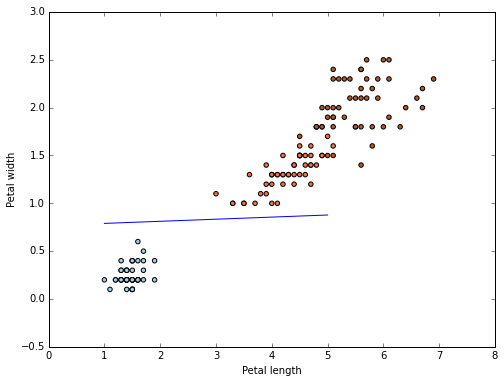

In [13]:
# Initialize weight vector and learning rate 
theta = np.random.randn(Y.shape[1]+1)
theta = theta / np.linalg.norm(theta)
rate = 0.1

# Add bias unit to input vectors
bias = np.ones(len(iris.data)).reshape(len(iris.data[:,:2]), 1)
data = np.hstack((bias, iris.data[:,2:]))

# Learn a decision boundary and plot the results
theta = learn(theta, data)

# Function for obtaining the value of a boundary plot 
def line(x):
    return theta[0]/-theta[2] + x*(theta[1]/-theta[2])
    
plt.figure(figsize=(8,6))
plt.scatter(Y[:, 0], Y[:, 1], c=Z, cmap=plt.cm.Paired)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.plot([1,5],[line(1),line(5)])
plt.xlim((0,8))
plt.ylim((-0.5,3))
fig.show()

# Proof Sketch for Convergence of the Learning Algorithm

To demonstrate that the perceptron learning algorithm is guaranteed to find a good decision boundary in a finite number of steps if the data is linearly seperable, we can first assume that there is exists a region of good solution vectors. (Content in progress...)